In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import csv
import random

housing = pd.read_csv("C:/Users/mjoy/Machine-Learning-Project/train.csv")
#full = pd.read_csv("AmesHousing.csv")

In [19]:
#housing.length = housing['YrSold'] - [housing.YearBuilt ]
#length houses in someones possesion


In [20]:
#get total square footage of house
housing = housing.assign(totalsq = housing.TotalBsmtSF + housing.GrLivArea)

In [21]:
#fill categorical variables that have Na as category
housing.head()
missings = ["Alley", "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1", 
"BsmtFinType2", "FireplaceQu", "GarageType","GarageFinish","GarageQual",
"GarageCond", "PoolQC", "Fence","MiscFeature","GarageYrBlt"]
housing[missings] = housing[missings].fillna(value = "None")
len(housing)

1460

In [22]:
housing.isnull().sum()
cols = housing.columns[housing.isnull().any()].tolist()
cols = cols[1:4]
housing = housing.dropna(axis = 0, how = "any", subset = cols)
#Lot Frontage has 259 missing values
#GarageYrBlt has 81 each -> because the property doesn't have a Garage
#MasVnrType and MasVnrArea have 8 missing values each
#Electrical has one missing values=1) & housing
len(housing)
print(housing.SalePrice.isnull().sum())

0


In [23]:
from pandas.api.types import CategoricalDtype

#convert categorical ordinal columns
catcols = housing[['ExterQual', 'ExterCond', 'BsmtQual',"BsmtCond",
           "BsmtExposure", "HeatingQC",
          "KitchenQual", "FireplaceQu", "GarageType","GarageQual",
          "GarageCond","PoolQC"]]
labels = CategoricalDtype(['None','Po','Fa','TA','Gd','Ex'], ordered = True)
catcols = catcols.apply(lambda x: x.astype('category').cat.codes)


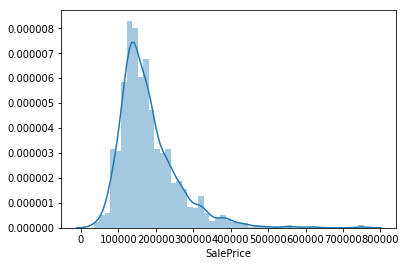

In [24]:
#histogram of sales prices
sns.distplot(housing['SalePrice']);
#we can see it is skewed to left so we need to normalize

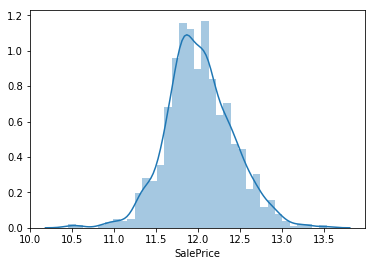

In [25]:
sns.distplot(np.log(housing['SalePrice']))


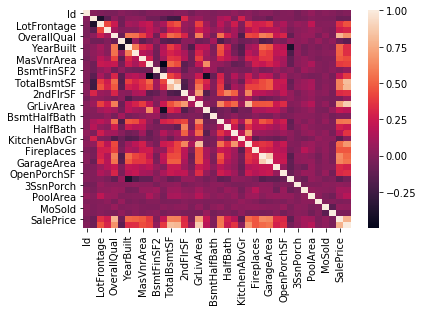

In [26]:
sns.heatmap(housing.corr())

In [27]:
#look at correlation of each var to sale price
corr_num = housing.corr()
#corr_num['SalePrice'].
#corr_num['SalePrice'].sort_values(ascending=False)



In [28]:
#get variables that have non-zero correlation w/ SalePrice

corr_var = [corrdf[corrdf['SalePrice'] == i].index.tolist() for i in corrdf['SalePrice'] if i != 0]
corr_var

NameError: name 'corrdf' is not defined

In [46]:
[item for sublist in corr_var for item in sublist if item in housing.columns.values]
# for i in corr_var:
#     for j in housing.columns:
#         if i is j:
#             print(i,j)
    
    
   # housing.drop(housing.columns[corr_var], axis =1 )

NameError: name 'corr_var' is not defined

(0, 15000)

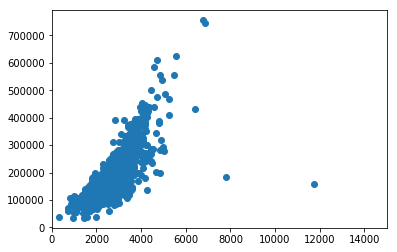

In [47]:
#look at LotArea against Price
fig = plt.figure()
sub1 = fig.add_subplot(111)
sub1.scatter(x = housing.totalsq, y = housing.SalePrice)
sub1.set_xlim(0, 15000)

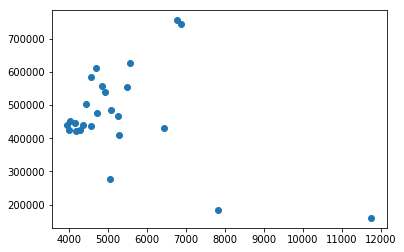

25


In [48]:
#examinig outliers by computing abs value of zscore and more than 3 sd from mean
total_price = housing[["totalsq", "SalePrice"]]
outliers = total_price[(np.abs(stats.zscore(total_price)) > 3)]
outliers = outliers.drop_duplicates()
plt.scatter(x=outliers.totalsq, y = outliers.SalePrice)
plt.show()
print(len(outliers))
#we can see that there are 25 outliers and they are from homes above 4000 sq ft

In [49]:
#remove outliers from data frame 
out = housing[(np.abs(stats.zscore(housing[["totalsq", "SalePrice"]])) < 3).all(axis=1)]
out = out.drop_duplicates()

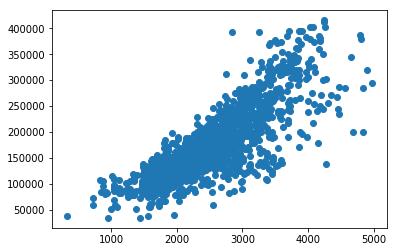

In [50]:
#check to makesure outliers are not in  dataset
plt.scatter(x=out.totalsq, y = out.SalePrice)
plt.show()


In [51]:
#convert non-ordinal categorical to dummyvars
housing_dumm = pd.get_dummies(out)

In [52]:
from fancyimpute import KNN

In [53]:
#impute missing values w/ KNN 
housing_y = housing_dumm.SalePrice
housing_x = housing_dumm.drop('Id', axis = 1)
housing_filled = pd.DataFrame(KNN(k=3).complete(housing_x))

Imputing row 1/1426 with 0 missing, elapsed time: 5.204
Imputing row 101/1426 with 0 missing, elapsed time: 5.206
Imputing row 201/1426 with 1 missing, elapsed time: 5.207
Imputing row 301/1426 with 0 missing, elapsed time: 5.209
Imputing row 401/1426 with 0 missing, elapsed time: 5.210
Imputing row 501/1426 with 0 missing, elapsed time: 5.211
Imputing row 601/1426 with 0 missing, elapsed time: 5.213
Imputing row 701/1426 with 0 missing, elapsed time: 5.214
Imputing row 801/1426 with 0 missing, elapsed time: 5.216
Imputing row 901/1426 with 0 missing, elapsed time: 5.218
Imputing row 1001/1426 with 0 missing, elapsed time: 5.219
Imputing row 1101/1426 with 0 missing, elapsed time: 5.221
Imputing row 1201/1426 with 0 missing, elapsed time: 5.222
Imputing row 1301/1426 with 0 missing, elapsed time: 5.224
Imputing row 1401/1426 with 0 missing, elapsed time: 5.225


In [56]:
#check to make ure no more missing values
print(housing_x.isnull().sum().sum())
print(len(housing_x))
print(housing_filled.isnull().sum().sum())
print(len(housing_filled))


255
1426
0
1426


In [57]:
#standardize data
from sklearn.preprocessing import StandardScaler
scaler = sklearn.preprocessing.StandardScaler().fit(housing_filled)
x_housing = pd.DataFrame(scaler.fit_transform(housing_filled))
x_housing.columns = list(housing_x)


In [58]:
# #covariance matrix of standardized data 
# mean_vec = np.mean(x_housing, axis=0)
# # cov_mat = (x_housing - mean_vec).T.dot((x_housing - mean_vec)) / (x_housing.shape[0]-1)
# print('Covariance matrix \n%s' %cov_mat)

In [59]:
# #Perform eigendecomposition on covariance matrix
# eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
# print('Eigenvalues:')
# [i[0] for i in eig_pairs]


In [62]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 100, random_state = 42).fit(x_housing)
# t_pca = pca.transform(x_housing)
# #plt.plot(pcaR,'o', markersize=7, color='blue', alpha=0.5, label='class1')
# var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
# print(x_housing.shape)
# print(t_pca.shape)
# plt.plot(var1, 'ro-',alpha = .5)
# plt.scatter(t_pca[:,0], t_pca[:,1],edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('spectral', 10)
#                              )
# #pca = PCA(n_components = 'mle').fit_transform(train_x)


In [63]:
#randomforest classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import array

#create training and test data
train, test = train_test_split(x_housing, train_size =.8,
                              test_size = .2, random_state = 42)
test_y = test.SalePrice
test_x = test.drop('SalePrice', axis =1)
train_y = train.SalePrice
train_x = train.drop('SalePrice', axis =1)

,Importance
OverallQual,0.473232
totalsq,0.308456
BsmtFinSF1,0.015028
LotArea,0.013013
GarageCars,0.012302
GarageArea,0.012227
YearBuilt,0.011521
GrLivArea,0.009941
YearRemodAdd,0.009370
BsmtUnfSF,0.008317


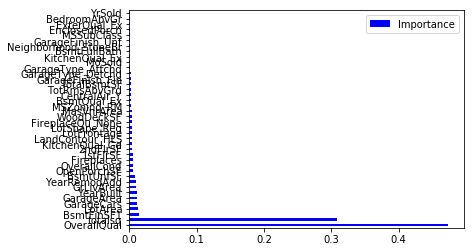

In [69]:
#run random forest regression to look at important features
model = RandomForestRegressor()
model.fit(train_x, train_y)
mod = pd.DataFrame(model.feature_importances_).T
mod
mod.columns = list(train_x)
mod = mod.T
mod.columns = ["Importance"]
mod.sort_values("Importance",axis =0, ascending = False, inplace = True)
mod.head(40).plot(kind = 'barh', color = 'b')
mod.head(40)

In [71]:
from boruta import BorutaPy



NameError: name 'train_x2' is not defined

In [72]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

rf_pred = model.predict(test_x)
rf_mse = mean_squared_error(test_y, rf_pred)
rf_rmse = np.sqrt(rf_mse)
#accuracy = accuracy_score(test_y, rf_pred)
print("RMSE:", rf_rmse)

RMSE: 0.37075863470849485


In [73]:
#cros validated 
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
rmse_cv = np.sqrt(-scores)
print("Scores", scores)
print("RMSE Mean", rmse_cv.mean())
print("RMSE SD:", rmse_cv.std())

Scores [-0.12107677 -0.07283373 -0.11971421 -0.17865739 -0.11782868 -0.14690016
 -0.08073499 -0.1365263  -0.10410575 -0.168553  ]
RMSE Mean 0.34998917456891976
RMSE SD: 0.04691136552276973


In [74]:
# from sklearn.model_selection import KFold

# cv = KFold(n_splits = 10, random_state = 42)

# resluts = []
# for train_x, train_y in cv.split(train_x):
#     probas - cv.fit(train[train_x], target[train_x]).predict_proba(train[test_y])
# #     results.append(Error_function)

NameError: name 'probas' is not defined

In [75]:
#new set with variables <= 0 removed
mod2 = mod[mod.Importance <= 0]
drops = list(mod2.index)
x_housing2 = x_housing.drop(drops, axis = 1)

#x_housing2 = x_housing.drop(housing[])
train2, test2 = train_test_split(x_housing2, train_size =.8,
                              test_size = .2, random_state = 42)
test_y2 = test2.SalePrice
test_x2 = test2.drop('SalePrice', axis =1)
train_y2 = train2.SalePrice
train_x2 = train2.drop('SalePrice', axis =1)


In [ ]:
model2 = RandomForestRegressor()


In [ ]:
feat_selector = BorutaPy(model, n_estimators = 'auto', verbose = 2, random_state = 42)
feat_selector.fit(train_x2.values, train_y2.values.ravel())
feat_selector.ranking_
feat_selector.transform(train_x2)

In [17]:
corr_num = x_housing2.corr()
print (corr_num['SalePrice'].sort_values(ascending=False))

NameError: name 'x_housing2' is not defined

In [ ]:
x_housing2.GarageArea.corr(x_housing2.GarageCars)
x_housing2.SalePrice

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(train_x, train_y)
plt.plot(X_poly)

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# predictors=['x']

# predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

lass = linear_model.Lasso(random_state = 42)
clf = GridSearchCV(lass, tuned_parameters, cv=n_folds, refit=False)
clf.fit(train_x2, train_y2)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors
#Initialize the dataframe for storing coefficients.
# lass = [0] * 10
# lass_mod = [0] * 10
# col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
# ind = [i for i in alpha_lasso]
# coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

# #models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}

# #model w/ lasso regression
# for i in alpha_lasso:
#     lass = linear_model.LassoCV(alphas = i, random_state = 42, cv = 10,
#                                 tol = .001)
#     lass_mod = lass.fit(train_x2, train_y2)
#     coef_matrix_lasso.iloc[i,] = lass_mod.predict(test_x2)

  #  lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

In [ ]:
#cros validated new set

scores2 = cross_val_score(lass_mod.fit, train_x2, train_y2, scoring="neg_mean_squared_error", cv=10)
rmse_cv = np.sqrt(-scores)
print("Scores", scores)
print("RMSE Mean", rmse_cv.mean())
print("RMSE SD:", rmse_cv.std()) 

In [ ]:
##### from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest

#ignore warnings
np.seterr(divide='ignore', invalid='ignore')

#feature union
features = []
features.append(('pca', PCA(n_components = 6)))
features.append(('best_k', SelectKBest(k=4)))
feature_union = FeatureUnion(features)

#estimators for pipeline
estimators = []
estimators.append(('feature_union', feature_union))
#estimators.append(('rand_forest', RandomForestRegressor()))
estimators.append(('lasso', Lasso()))
model = Pipeline(estimators)

# evaluate accuracy of pipeline 
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(mod, rf_pred, train_y, cv=kfold)
print(results.mean())

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest

#remove features w/ low variance
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
pd.DataFrame(sel.fit_transform(housing_t))

#select features according to k-highest score
sklearn.feature_selection.SelectKBest